In [7]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory

100%|██████████| 186/186 [00:00<00:00, 193.95it/s]


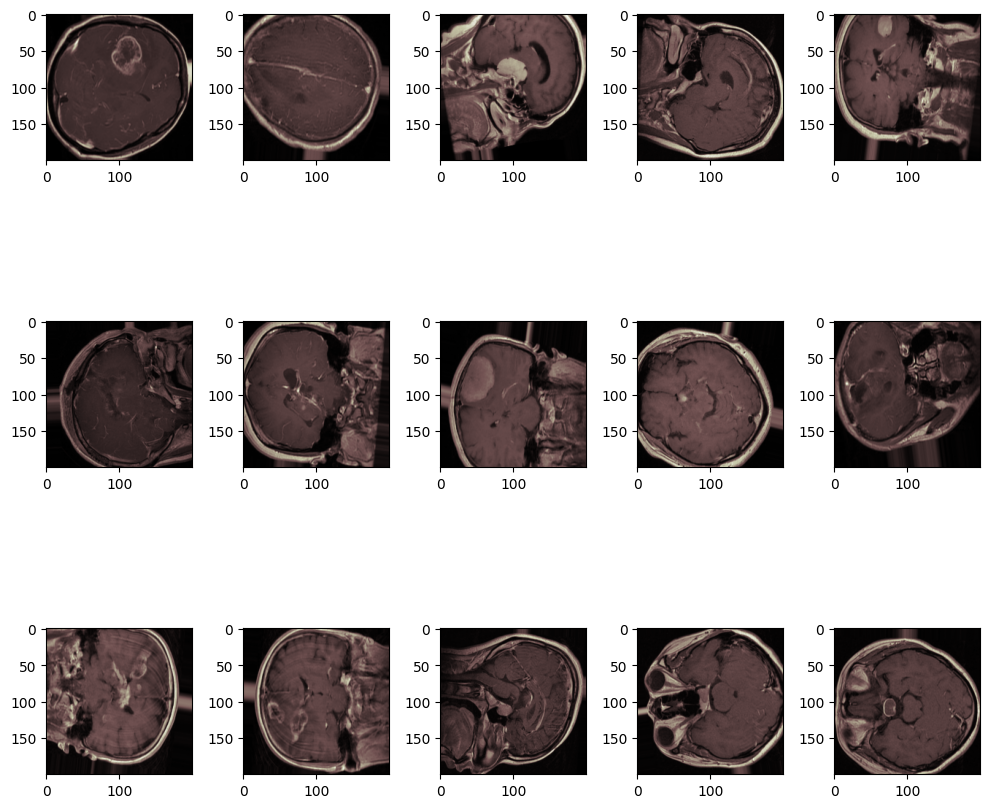

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

In [3]:
net = ResNet50(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2023-12-08 01:36:17.524136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 01:36:17.833550: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [4]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-ResNet50.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

Epoch 1/50


2023-12-08 01:36:30.217725: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-08 01:36:30.797627: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-08 01:36:30.797649: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-08 01:36:30.797768: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-08 01:36:31.359764: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 1.2418 - accuracy: 0.5353
Epoch 1: saving model to model-ResNet50.h5
Epoch 1: 21.58 seconds
264/264 [==============================] - 22s 60ms/step - loss: 1.2418 - accuracy: 0.5353 - val_loss: 2.1086 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.7334 - accuracy: 0.7223
Epoch 2: saving model to model-ResNet50.h5
Epoch 2: 14.55 seconds
264/264 [==============================] - 15s 55ms/step - loss: 0.7334 - accuracy: 0.7221 - val_loss: 8.0352 - val_accuracy: 0.3605 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.5118 - accuracy: 0.8080
Epoch 3: saving model to model-ResNet50.h5
Epoch 3: 14.44 seconds
264/264 [==============================] - 14s 55ms/step - loss: 0.5121 - accuracy: 0.8078 - val_loss: 11.1709 - val_accuracy: 0.3359 - lr: 1.0000e-04
Epoch 4/50
263/264 [============================>.] - ETA: 0s - loss: 0.40

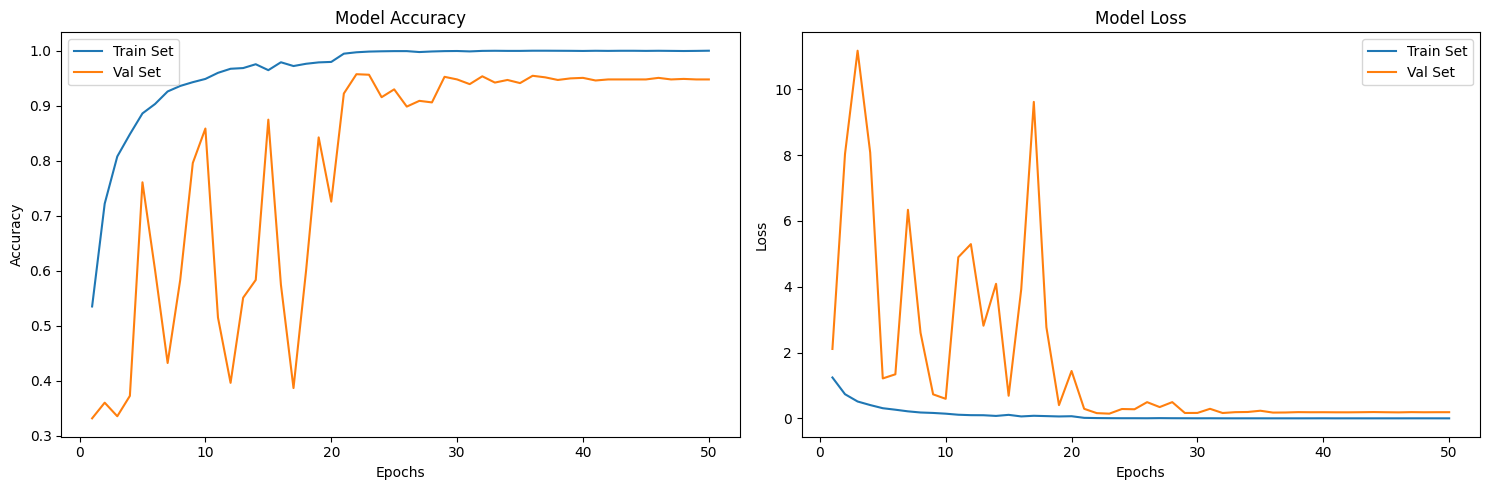

In [5]:
draw_curve(history)

20/20 [==============================] - 0s 16ms/step - loss: 0.2579 - accuracy: 0.9397
Test Accuracy:  93.97
              precision    recall  f1-score   support

      glioma     0.9514    0.9580    0.9547       286
  meningioma     0.9037    0.8592    0.8809       142
   pituitary     0.9476    0.9731    0.9602       186

    accuracy                         0.9397       614
   macro avg     0.9342    0.9301    0.9319       614
weighted avg     0.9392    0.9397    0.9393       614



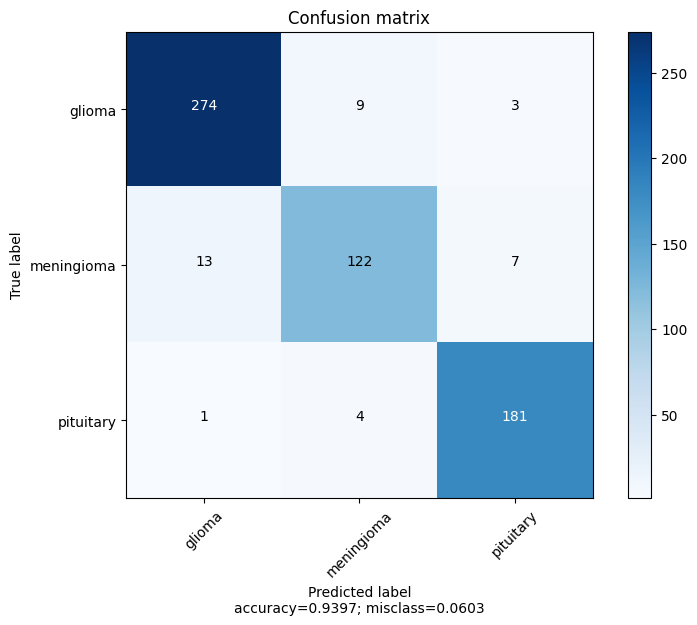

In [6]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

In [7]:
%reset -f

100%|██████████| 186/186 [00:00<00:00, 196.71it/s]


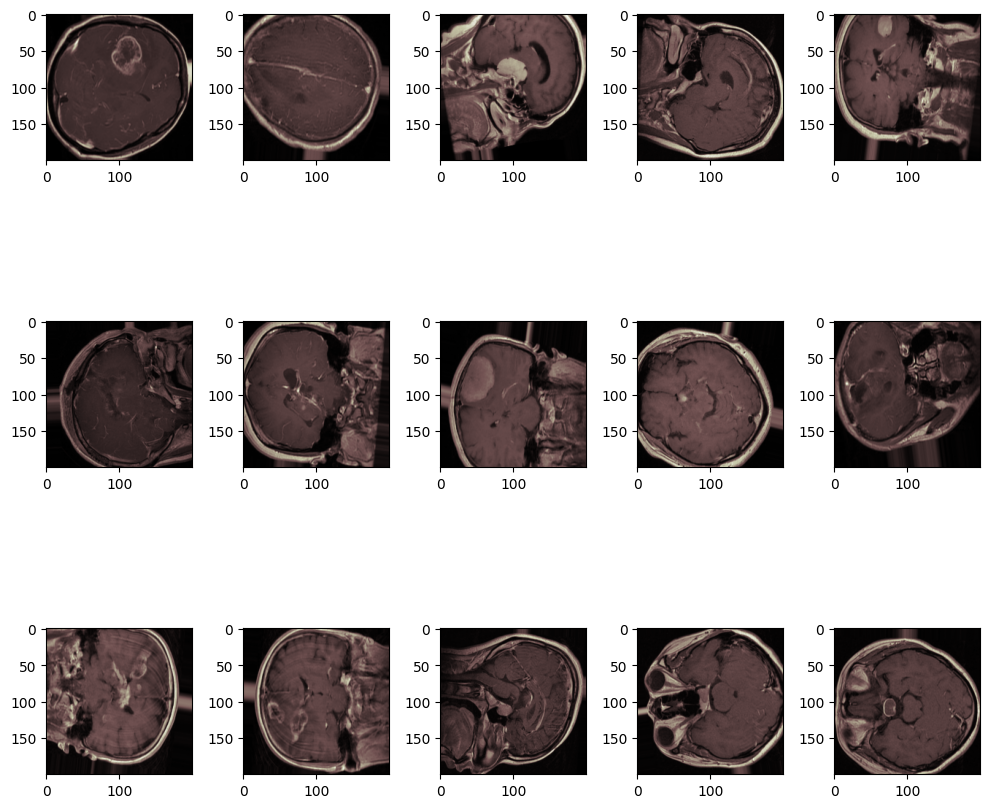

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)


2023-12-08 02:14:08.896575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 02:14:09.212976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/50


2023-12-08 02:14:18.865739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-08 02:14:19.424084: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-12-08 02:14:19.424124: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2023-12-08 02:14:19.424348: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-12-08 02:14:19.990102: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


264/264 [==============================] - ETA: 0s - loss: 1.2307 - accuracy: 0.5483
Epoch 1: saving model to model-ResNet50.h5
Epoch 1: 21.56 seconds
264/264 [==============================] - 22s 59ms/step - loss: 1.2307 - accuracy: 0.5483 - val_loss: 4.6272 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.7308 - accuracy: 0.7289
Epoch 2: saving model to model-ResNet50.h5
Epoch 2: 14.08 seconds
264/264 [==============================] - 14s 53ms/step - loss: 0.7306 - accuracy: 0.7291 - val_loss: 7.9184 - val_accuracy: 0.3463 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.5106 - accuracy: 0.8062
Epoch 3: saving model to model-ResNet50.h5
Epoch 3: 14.27 seconds
264/264 [==============================] - 14s 54ms/step - loss: 0.5108 - accuracy: 0.8062 - val_loss: 5.2899 - val_accuracy: 0.4696 - lr: 1.0000e-04
Epoch 4/50
264/264 [==============================] - ETA: 0s - loss: 0.367

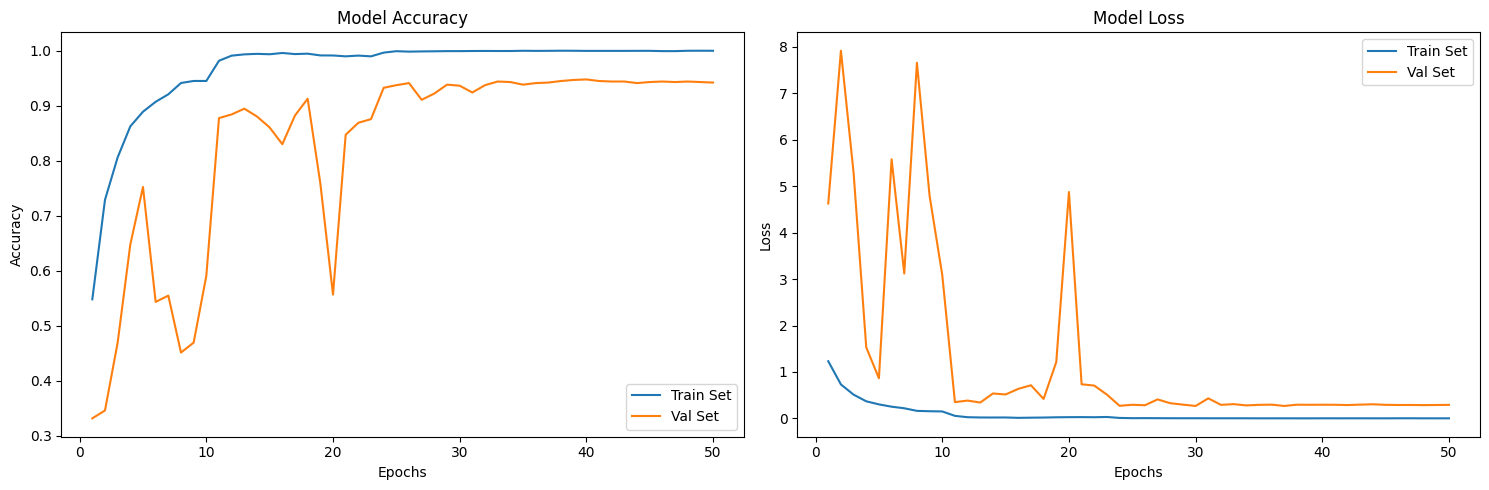

20/20 [==============================] - 0s 16ms/step - loss: 0.3605 - accuracy: 0.9186
Test Accuracy:  91.86
              precision    recall  f1-score   support

      glioma     0.9495    0.9196    0.9343       286
  meningioma     0.8462    0.8521    0.8491       142
   pituitary     0.9278    0.9677    0.9474       186

    accuracy                         0.9186       614
   macro avg     0.9078    0.9131    0.9103       614
weighted avg     0.9190    0.9186    0.9186       614



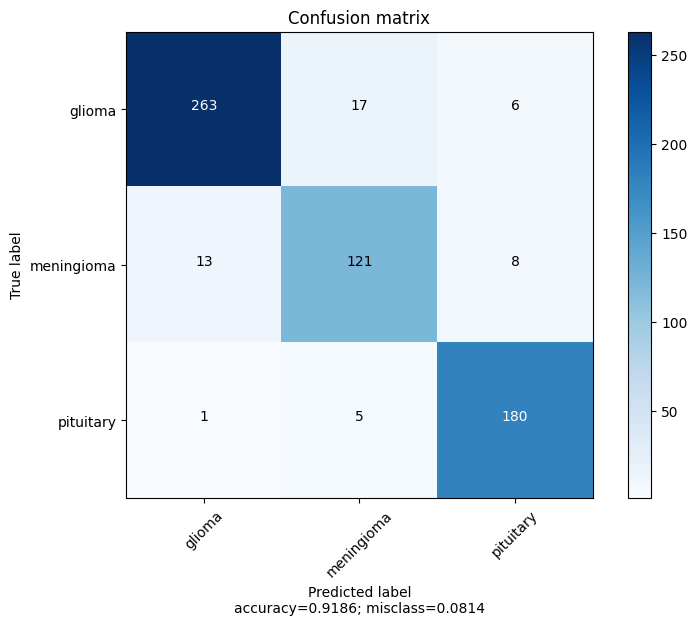

In [2]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = ResNet50(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-ResNet50.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f


100%|██████████| 186/186 [00:00<00:00, 194.00it/s]


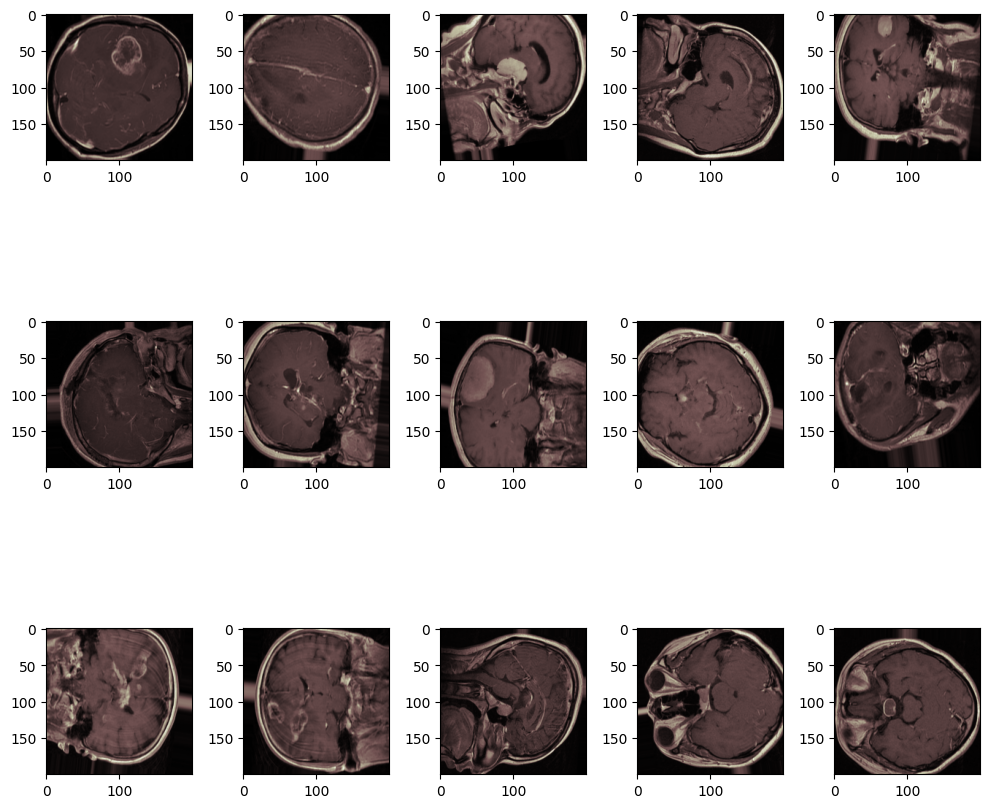

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 1.2322 - accuracy: 0.5362
Epoch 1: saving model to model-ResNet50.h5
Epoch 1: 18.98 seconds
264/264 [==============================] - 19s 58ms/step - loss: 1.2314 - accuracy: 0.5366 - val_loss: 3.6280 - val_accuracy: 0.3321 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.7252 - accuracy: 0.7322
Epoch 2: saving model to model-ResNet50.h5
Epoch 2: 14.35 seconds
264/264 [==============================] - 14s 54ms/step - loss: 0.7247 - accuracy: 0.7321 - val_loss: 8.9757 - val_accuracy: 0.3700 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.5132 - accuracy: 0.8086
Epoch 3: saving model to model-ResNet50.h5
Epoch 3: 14.27 seconds
264/264 [==============================] - 14s 54ms/step - loss: 0.5126 - accuracy: 0.8089 - val_loss: 1.1743 - val_accuracy: 0.6338 - lr: 1.0000e-04
Epoc

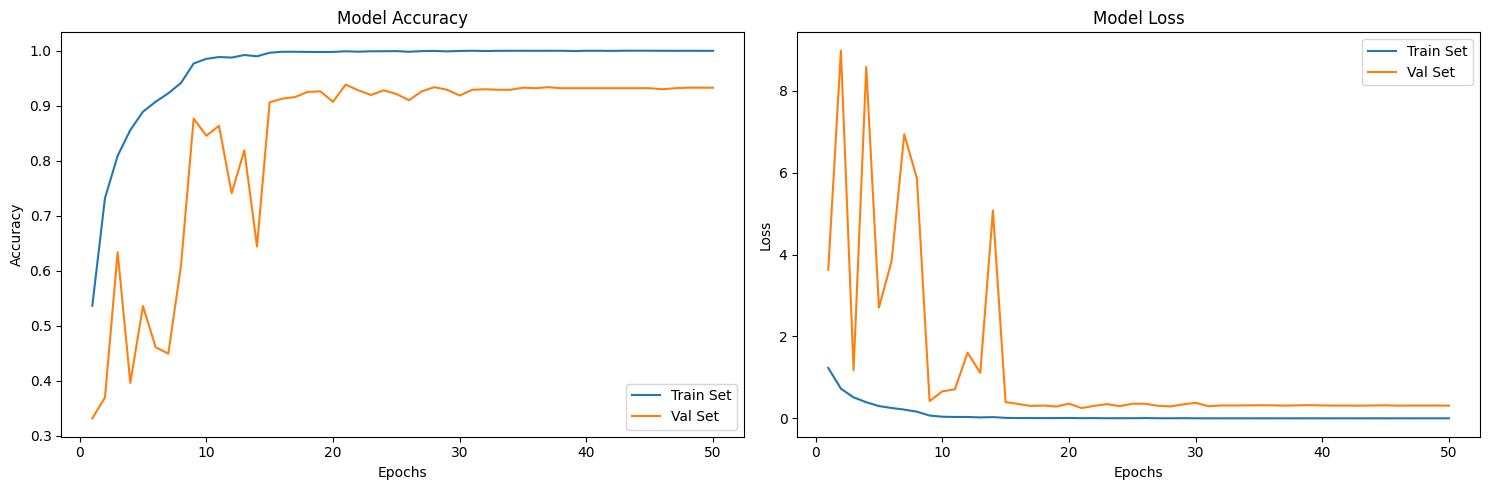

20/20 [==============================] - 0s 17ms/step - loss: 0.3782 - accuracy: 0.9316
Test Accuracy:  93.16
              precision    recall  f1-score   support

      glioma     0.9710    0.9371    0.9537       286
  meningioma     0.8681    0.8803    0.8741       142
   pituitary     0.9227    0.9624    0.9421       186

    accuracy                         0.9316       614
   macro avg     0.9206    0.9266    0.9233       614
weighted avg     0.9326    0.9316    0.9318       614



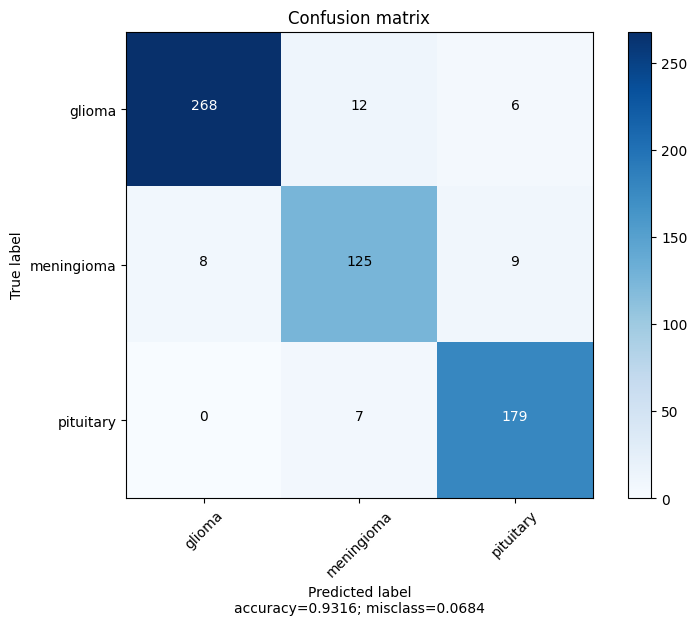

In [4]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = ResNet50(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-ResNet50.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 193.38it/s]


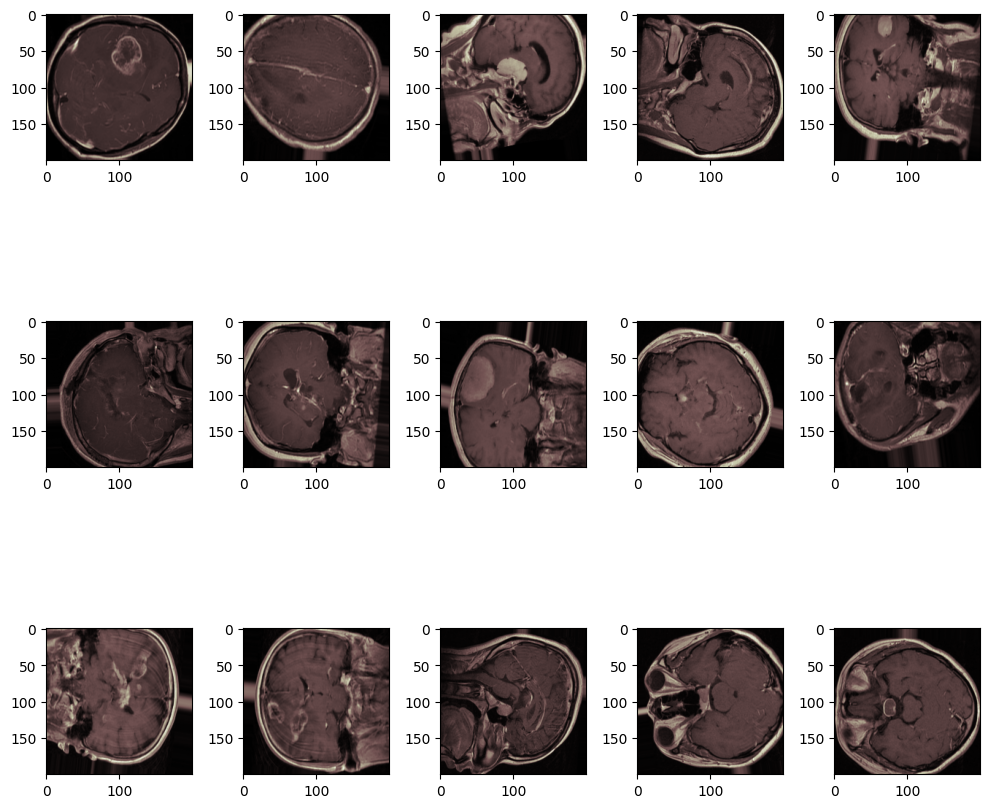

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 1.2415 - accuracy: 0.5340
Epoch 1: saving model to model-ResNet50.h5
Epoch 1: 18.42 seconds
264/264 [==============================] - 18s 57ms/step - loss: 1.2401 - accuracy: 0.5346 - val_loss: 3.0218 - val_accuracy: 0.4820 - lr: 1.0000e-04
Epoch 2/50
264/264 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.7291
Epoch 2: saving model to model-ResNet50.h5
Epoch 2: 14.23 seconds
264/264 [==============================] - 14s 54ms/step - loss: 0.7151 - accuracy: 0.7291 - val_loss: 4.8733 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.5269 - accuracy: 0.8124
Epoch 3: saving model to model-ResNet50.h5
Epoch 3: 14.29 seconds
264/264 [==============================] - 14s 54ms/step - loss: 0.5266 - accuracy: 0.8126 - val_loss: 8.3118 - val_accuracy: 0.3359 - lr: 1.0000e-04
Epoc

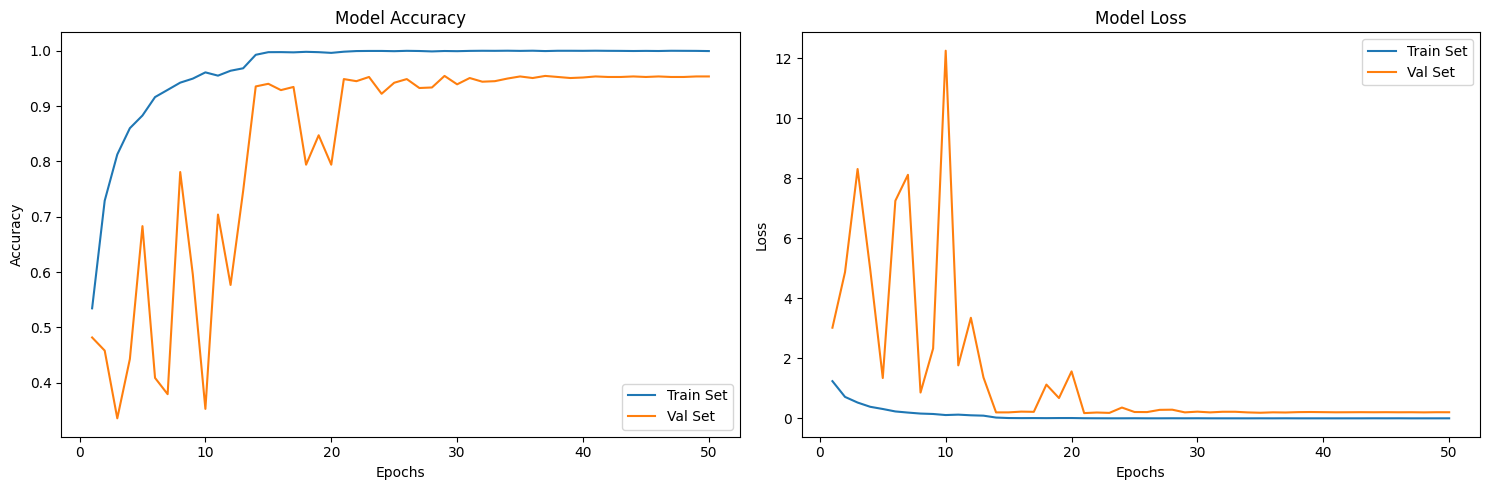

20/20 [==============================] - 0s 16ms/step - loss: 0.2223 - accuracy: 0.9495
Test Accuracy:  94.95
              precision    recall  f1-score   support

      glioma     0.9713    0.9476    0.9593       286
  meningioma     0.8926    0.9366    0.9141       142
   pituitary     0.9624    0.9624    0.9624       186

    accuracy                         0.9495       614
   macro avg     0.9421    0.9488    0.9452       614
weighted avg     0.9504    0.9495    0.9498       614



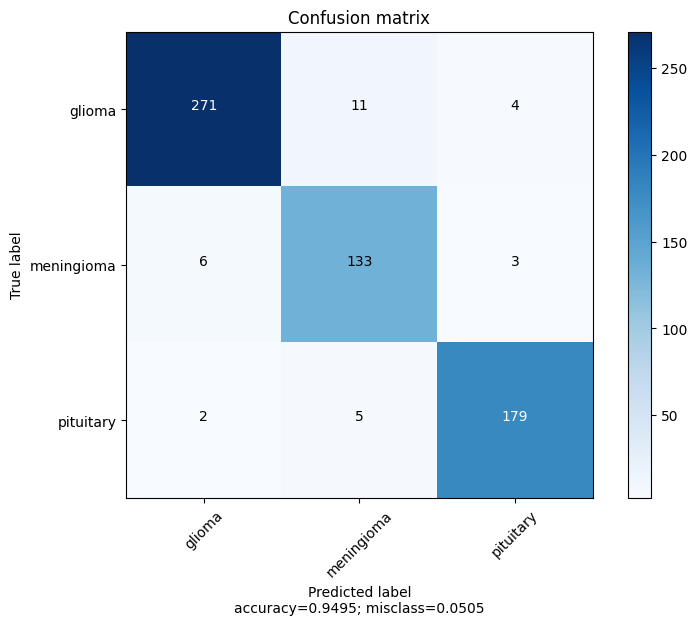

In [6]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = ResNet50(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-ResNet50.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)
%reset -f

100%|██████████| 186/186 [00:00<00:00, 194.60it/s]


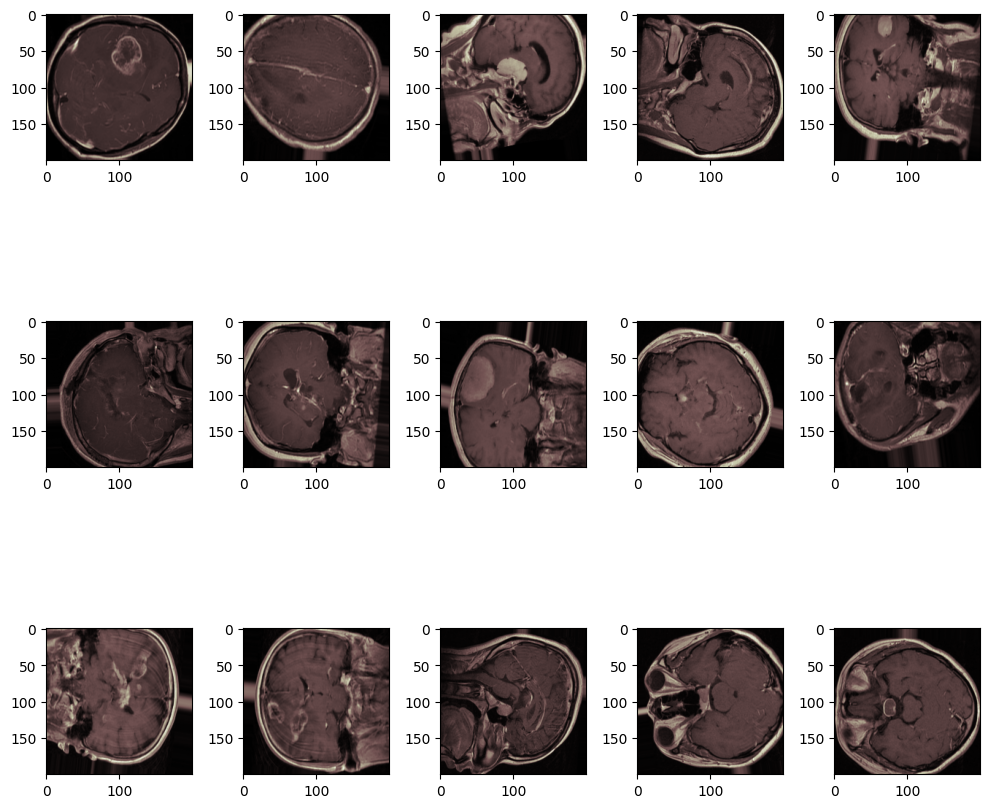

(614, 200, 200, 3)
(10536, 200, 200, 3)
(614, 3)
(10536, 3)
Epoch 1/50
263/264 [============================>.] - ETA: 0s - loss: 1.2535 - accuracy: 0.5259
Epoch 1: saving model to model-ResNet50.h5
Epoch 1: 18.47 seconds
264/264 [==============================] - 18s 58ms/step - loss: 1.2529 - accuracy: 0.5262 - val_loss: 2.7805 - val_accuracy: 0.3899 - lr: 1.0000e-04
Epoch 2/50
263/264 [============================>.] - ETA: 0s - loss: 0.7459 - accuracy: 0.7283
Epoch 2: saving model to model-ResNet50.h5
Epoch 2: 14.39 seconds
264/264 [==============================] - 14s 55ms/step - loss: 0.7457 - accuracy: 0.7283 - val_loss: 3.5525 - val_accuracy: 0.3520 - lr: 1.0000e-04
Epoch 3/50
263/264 [============================>.] - ETA: 0s - loss: 0.5104 - accuracy: 0.8032
Epoch 3: saving model to model-ResNet50.h5
Epoch 3: 14.42 seconds
264/264 [==============================] - 14s 55ms/step - loss: 0.5105 - accuracy: 0.8032 - val_loss: 4.7799 - val_accuracy: 0.4867 - lr: 1.0000e-04
Epoc

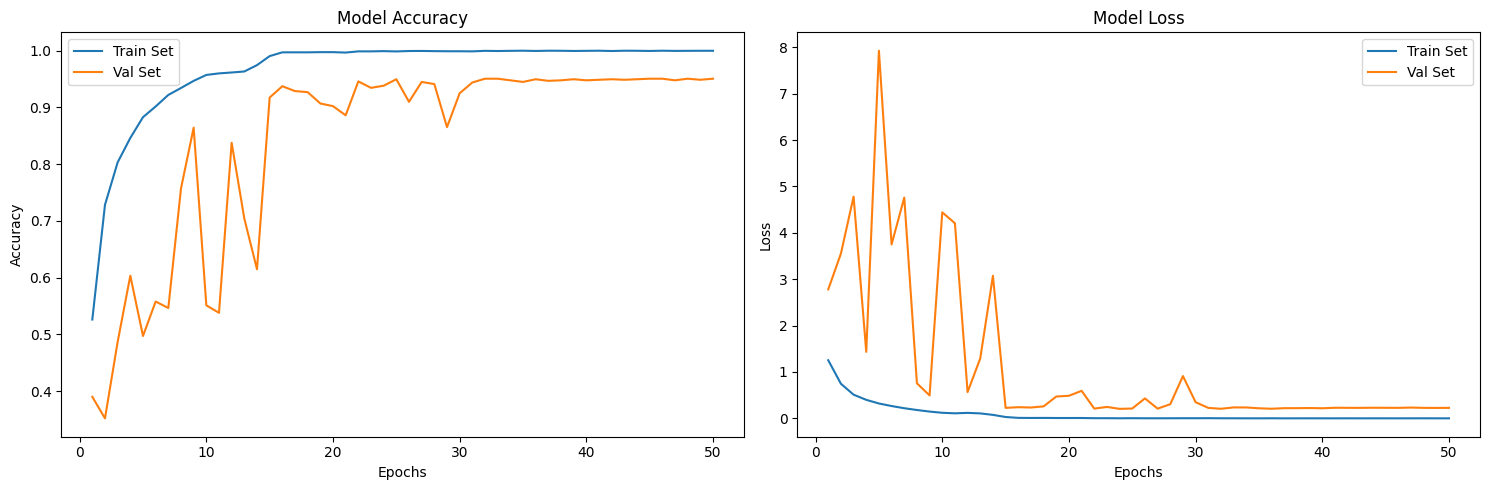

20/20 [==============================] - 0s 16ms/step - loss: 0.3056 - accuracy: 0.9349
Test Accuracy:  93.49
              precision    recall  f1-score   support

      glioma     0.9643    0.9441    0.9541       286
  meningioma     0.8690    0.8873    0.8780       142
   pituitary     0.9418    0.9570    0.9493       186

    accuracy                         0.9349       614
   macro avg     0.9250    0.9295    0.9271       614
weighted avg     0.9354    0.9349    0.9351       614



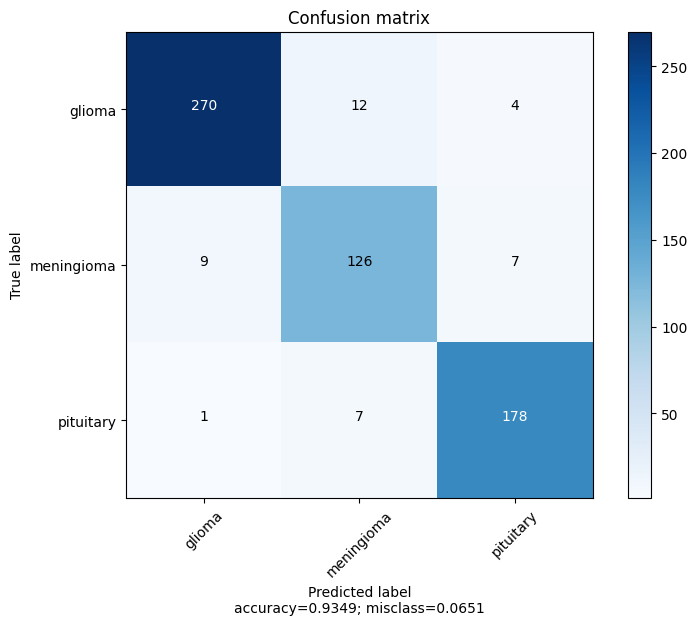

In [8]:
labels = ['glioma', 'meningioma', 'pituitary']
data_path = '/root/autodl-tmp/dataset/figshare_MBTD/augmented'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)


net = ResNet50(weights=None, include_top=False, input_shape=(image_size, image_size, 3))
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='model-ResNet50.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])


draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)